In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

In [ ]:
training_data = datasets.LFWPairs(
    root="data",
    download=True,
    transform=ToTensor()
)

test_data = datasets.LFWPairs(
    root="data",
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


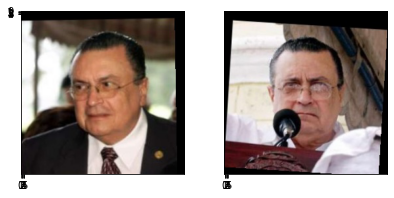

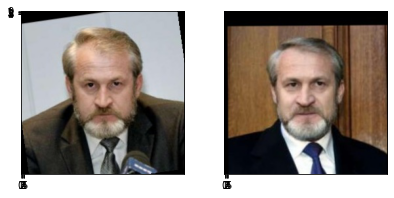

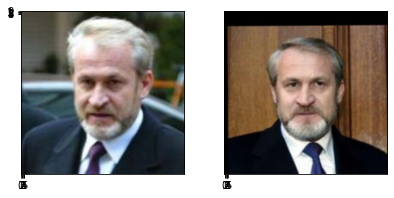

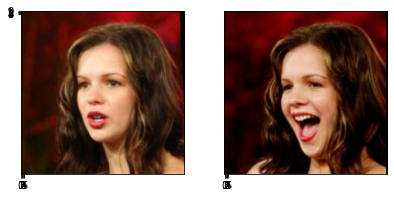

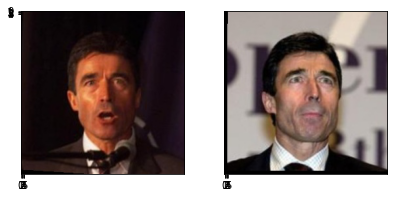

In [ ]:
n_samples = 5

for i in range(n_samples):
  n = 6
  m = np.reshape(np.linspace(0,1,n**2), (n,n))
  plt.figure(figsize=(14,3))

  plt.subplot(141)
  plt.imshow(np.transpose(training_data[i][0], (1, 2, 0)))
  plt.xticks(range(n))
  plt.yticks(range(n))

  plt.subplot(142)
  plt.imshow(np.transpose(training_data[i][1], (1, 2, 0)))
  plt.yticks([])
  plt.xticks(range(n))

plt.show()

In [ ]:
for i in range(n_samples):
  print(training_data[i][2])

1
1
1
1
1


In [ ]:
train_dataloader = DataLoader(training_data, 
                          shuffle=True,
                          num_workers=2,
                          batch_size=64)

test_dataloader = DataLoader(test_data, 
                         shuffle=True,
                         num_workers=2,
                         batch_size=64)

In [ ]:
batch = next(iter(train_dataloader))
len(batch), len(batch[0]), len(batch[1]), len(batch[2])

(3, 64, 64, 64)

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(38400, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

In [ ]:
siamese_net = SiameseNetwork().cuda()
loss_func = ContrastiveLoss()
opt = optim.Adam(siamese_net.parameters(), lr = 0.0003)

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(50):

    # Iterate over batches
    for i, (first_img, second_img, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        first_img, second_img, label = first_img.cuda(), second_img.cuda(), label.cuda()
        # first_img, second_img, label = first_img, second_img, label

        # Zero the gradients
        opt.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = siamese_net(first_img, second_img)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = loss_func(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        opt.step()

        # Every 10 batches print out the loss
        if i % 100 == 0 :
            print(f"Epoch number {epoch+1}\nloss: {loss_contrastive.item():.2f}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

Epoch number 1
loss: 2.18

Epoch number 2
loss: 1.34

Epoch number 3
loss: 1.20

Epoch number 4
loss: 1.20

Epoch number 5
loss: 1.18

Epoch number 6
loss: 1.13

Epoch number 7
loss: 1.30

Epoch number 8
loss: 1.16

Epoch number 9
loss: 1.17

Epoch number 10
loss: 1.28

Epoch number 11
loss: 1.14

Epoch number 12
loss: 1.15

Epoch number 13
loss: 1.19

Epoch number 14
loss: 1.35

Epoch number 15
loss: 1.34

Epoch number 16
loss: 1.08

Epoch number 17
loss: 1.18

Epoch number 18
loss: 1.17

Epoch number 19
loss: 1.10

Epoch number 20
loss: 1.23

Epoch number 21
loss: 1.13

Epoch number 22
loss: 1.15

Epoch number 23
loss: 1.13

Epoch number 24
loss: 1.08

Epoch number 25
loss: 1.08

Epoch number 26
loss: 1.09

Epoch number 27
loss: 1.08

Epoch number 28
loss: 1.09

Epoch number 29
loss: 1.09

Epoch number 30
loss: 1.06

Epoch number 31
loss: 1.02

Epoch number 32
loss: 1.02

Epoch number 33
loss: 1.06

Epoch number 34
loss: 1.04

Epoch number 35
loss: 1.00

Epoch number 36
loss: 1.04

E

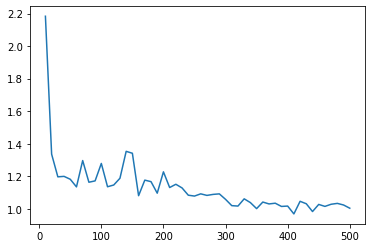

In [ ]:
plt.plot(counter, loss_history)
plt.show()

In [ ]:
batch_size = 64
TP = 0 # True Positive
TN = 0 # True Negative
FP = 0 # False Postive
FN = 0 # False Negative

for i, (first_img, second_img, label) in enumerate(test_dataloader, 0):
  if i == 93:
    break
  euclidean_distance = F.pairwise_distance(first_img, second_img)
  for j in range(batch_size):
    sum_euclidean = torch.sum(euclidean_distance[j])
    if (sum_euclidean) < 4100:
      prediction = 1
    else:
      prediction = 0

    if prediction == label[j]:
      if prediction == 1:
        TP += 1
      else:
        TN += 1

    else:
      if prediction == 1:
        FP += 1
      else:
        FN += 1


Accuracy = (TP+TN) / (TP+TN+FP+FN)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
Specificity = TN / (TN+FP)
F1_Score = 2 * ((Precision*Recall)/(Precision+Recall))

In [ ]:
print(f"Accuracy: {Accuracy:.2f}")
print(f"Precision: {Precision:.2f}")
print(f"Recall: {Recall:.2f}")
print(f"Specificity: {Specificity:.2f}")
print(f"F1-Score: {F1_Score:.2f}")

Accuracy: 0.59
Precision: 0.58
Recall: 0.65
Specificity: 0.54
F1-Score: 0.61


In [ ]:
cosine_sim = nn.CosineSimilarity()

In [ ]:
batch_size = 64
TP = 0
TN = 0
FP = 0
FN = 0
test_data_size = len(test_dataloader)
acc_history = []
predictions = []

for i, (first_img, second_img, label) in enumerate(test_dataloader, 0):
  if i == 93:
    break
  cosine_simularity = cosine_sim(first_img, second_img)
  for j in range(batch_size):
    sum_cosine = torch.sum(cosine_simularity[j])
    if (sum_euclidean) < 4100:
      prediction = 1
    else:
      prediction = 0

    if prediction == label[j]:
      if prediction == 1:
        TP += 1
      else:
        TN += 1

    else:
      if prediction == 1:
        FP += 1
      else:
        FN += 1


Accuracy = (TP+TN) / (TP+TN+FP+FN)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
Specificity = TN / (TN+FP)
F1_Score = 2 * ((Precision*Recall)/(Precision+Recall))

In [ ]:
print(f"Accuracy: {Accuracy:.2f}")
print(f"Precision: {Precision:.2f}")
print(f"Recall: {Recall:.2f}")
print(f"Specificity: {Specificity:.2f}")
print(f"F1-Score: {F1_Score:.2f}")

Accuracy: 0.50
Precision: 0.50
Recall: 1.00
Specificity: 0.00
F1-Score: 0.67
